## Encoder-Decoder

### Overview
In this notebook, we will:
- Load a small grayscale image dataset (10 training images of size 64x64) and a separate test dataset.
- Construct a denoising autoencoder. The encoder will reduce the dimensionality step-by-step with at least 4 convolutional layers that reduce spatial resolution, and the decoder will symmetrically reconstruct the image back.
- Introduce zero-mean Gaussian noise to the input images during training and learn to reconstruct the original clean images.
- Evaluate the model's performance on a separate test set and visualize the outputs.
- Monitor training and test performance over epochs to ensure we achieve a "good enough" performance level.


### Reasoning About the Task

We have a very small dataset (just 10 images) for training. Normally, deep learning networks thrive on large datasets, but we will try to achieve good performance by carefully choosing:
- A relatively small network architecture, balanced for the small dataset size.
- Enough training epochs to ensure overfitting to this small dataset is minimized but we still manage to denoise effectively.

We will:
1. Load a small set of grayscale natural images. We will use the STL10 dataset from PyTorch's torchvision, pick a subset of images, convert them to grayscale, and resize them to 64x64 for demonstration purposes.
2. Add Gaussian noise with varying amounts (up to a "meaningful maximum" standard deviation of 0.3). A noise level of 0.3 in the [0,1] normalized scale of image pixel intensity is quite substantial noise visually. We will vary noise level during training to ensure robustness.
3. Train the autoencoder to reconstruct the clean image from the noisy input. We will use Mean Squared Error (MSE) loss.
4. After training, we will test on a separate set of images that the network has never seen.
5. We will visualize:
    - The training and test loss curves over epochs.
    - The denoising results on test images: original clean image, noisy image input, and reconstructed denoised output.


### Criteria for "Good Enough" Performance
Considering the small dataset and the complexity of the task, a "really good" performance will be judged by:
 - The model producing reconstructions that are visually close to the clean input.
 - The MSE loss on the test set being relatively low (e.g., an MSE < 0.01 on a normalized [0,1] image might be considered good given the noise intensity).

We may tune:
 - The number of epochs (train until convergence).
 - The learning rate and optimizer.
 - The network size to ensure it can handle the complexity of the data.

We will stop training when the test set reconstruction looks visually acceptable and the MSE loss is sufficiently low.


In [ ]:
## import required packages

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.datasets import STL10
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity


In [ ]:
## Step 1: Prepare the dataset

transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# Load STL10 training-test set
stl_train = STL10(root='./data', split='train', download=True, transform=transform)
stl_test = STL10(root='./data', split='test', download=True, transform=transform)

# Just pick 10 images for training and 5 for test from this dataset.
train_images = [stl_train[i][0] for i in range(10)]
test_images = [stl_test[i][0] for i in range(5)]
new_test_images = [stl_test[i+6][0] for i in range(5)]

train_images = torch.stack(train_images)  # shape: [10, 1, 64, 64]
test_images = torch.stack(test_images)    # shape: [5, 1, 64, 64]
new_test_images = torch.stack(new_test_images)    # shape: [5, 1, 64, 64]

# Normalize images to [0,1] (CIFAR is already 0-1 in ToTensor)
# Just ensure data is in [0,1]
train_images = torch.clamp(train_images,0,1)
test_images = torch.clamp(test_images,0,1)
new_test_images = torch.clamp(new_test_images,0,1)


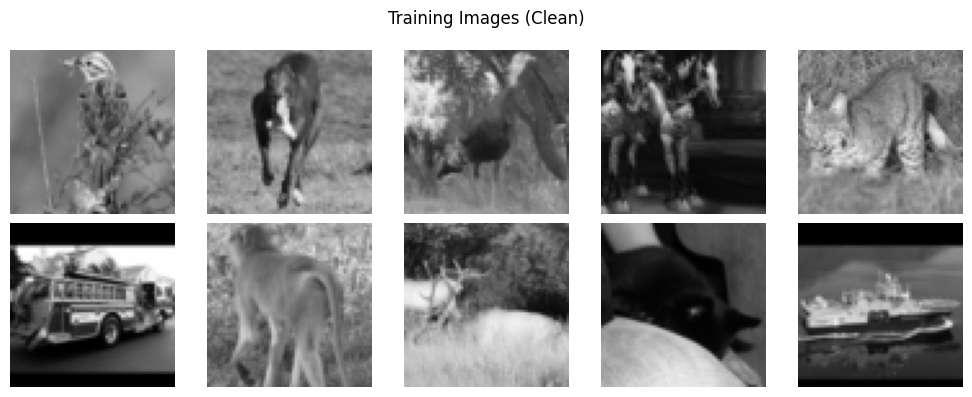

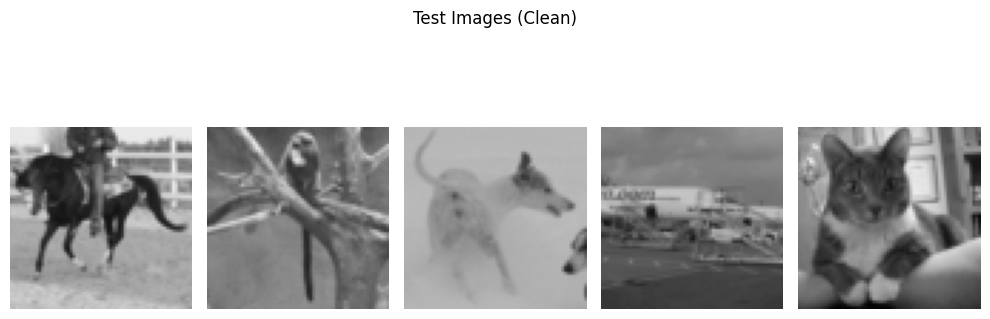

In [3]:
# Visualizing the training and test images before adding noise or passing through the model.
# These images are grayscale tensors of shape [N,1,H,W].

# train_images shape: [10,1,64,64]
# test_images  shape: [5,1,64,64]

# Let's visualize all the training images in a grid
fig, axs = plt.subplots(2, 5, figsize=(10,4))
fig.suptitle("Training Images (Clean)")

for i in range(10):
    r = i // 5
    c = i % 5
    axs[r, c].imshow(train_images[i,0], cmap='gray', vmin=0, vmax=1)
    axs[r, c].axis('off')

plt.tight_layout()
plt.show()

# Visualize the test images
fig, axs = plt.subplots(1, 5, figsize=(10,4))
fig.suptitle("Test Images (Clean)")

for i in range(5):
    axs[i].imshow(test_images[i,0], cmap='gray', vmin=0, vmax=1)
    axs[i].axis('off')

plt.tight_layout()
plt.show()


In [5]:
# We create a custom dataset to handle adding noise on the fly.

class DenoiseDataset(Dataset):
    def __init__(self, images, max_noise_std=0.3):
        """
        images: Tensor of shape [N,1,H,W], in [0,1]
        max_noise_std: maximum std dev of noise that we may apply
        """
        self.images = images
        self.max_noise_std = max_noise_std

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        clean_img = self.images[idx]  # shape [1,H,W]
        # Add zero-mean Gaussian noise with a random std up to max_noise_std
        noise_std = torch.rand(1).item() * self.max_noise_std
        noise = torch.randn_like(clean_img) * noise_std
        noisy_img = clean_img + noise
        # Clip to [0,1] range
        noisy_img = torch.clamp(noisy_img,0,1)
        return noisy_img, clean_img

train_dataset = DenoiseDataset(train_images, max_noise_std=0.3)
test_dataset = DenoiseDataset(test_images, max_noise_std=0.3)  

new_test_images = DenoiseDataset(new_test_images, max_noise_std=0.3)  # We also evaluate on new noisy test images


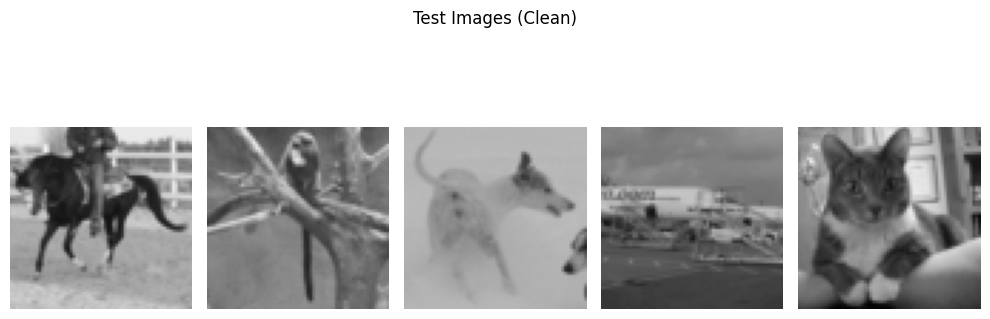

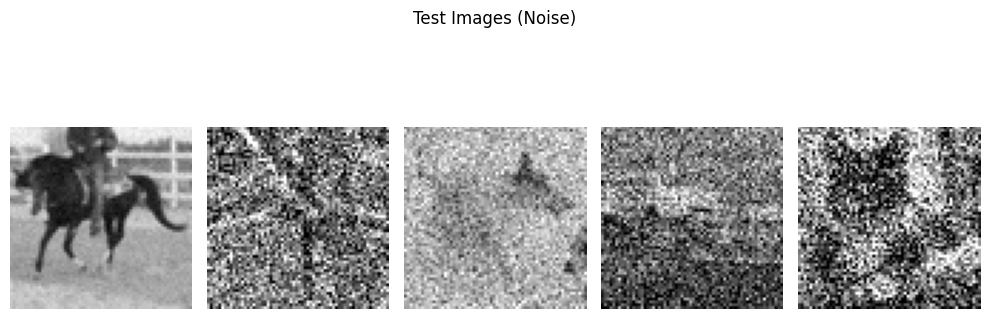

In [5]:
# Let's pick some test images, add noise and see how they look.
# We will visualize a test images: original clean and noisy.

test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False)
test_noisy_batch, test_clean_batch = next(iter(test_loader))

fig, axs = plt.subplots(1, 5, figsize=(10,4))
fig.suptitle("Test Images (Clean)")

for i in range(5):
    axs[i].imshow(test_clean_batch[i,0], cmap='gray', vmin=0, vmax=1)
    axs[i].axis('off')

plt.tight_layout()
plt.show()

# Visualize the test images
fig, axs = plt.subplots(1, 5, figsize=(10,4))
fig.suptitle("Test Images (Noise)")

for i in range(5):
    axs[i].imshow(test_noisy_batch[i,0], cmap='gray', vmin=0, vmax=1)
    axs[i].axis('off')

plt.tight_layout()
plt.show()


In [9]:
## Step 2: Define the Denoising Autoencoder
# We want at least 4 encoding layers and 4 decoding layers.
# Architecture reasoning:
# We can use convolutional layers with strides or pooling to reduce spatial dimension.
# For example:
# Encoder:
#   Input: 1 x 64 x 64
#   Conv(1->16), ReLU, 
#   Conv(16->32), ReLU, downsample spatially (stride 2)
#   Conv(32->64), ReLU, downsample spatially (stride 2)
#   Conv(64->128), ReLU, downsample again
# This would be 4 convolutional layers (with some downsampling)
#
# Decoder:
#   We reverse the process by using ConvTranspose layers to upsample back.
#   ConvTranspose(128->64), ReLU
#   ConvTranspose(64->32), ReLU
#   ConvTranspose(32->16), ReLU
#   ConvTranspose(16->1), Sigmoid (for output in [0,1])
#
# We'll use MSE loss for reconstruction.

class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        
        # Encoder
        # in: 1x64x64
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=2),  # 32x32
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2),  # 16x16
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=2), # 8x8
            nn.ReLU(True),
        )
        
        # Decoder
        # We do the inverse operations
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2), # 16x16
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),   # 32x32
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),   # 64x64
            nn.ReLU(True),
            nn.Conv2d(16, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # Encode
        encoded = self.encoder(x)
        # Decode
        decoded = self.decoder(encoded)
        return decoded
    

In [10]:
# Initialize datset, model, define loss and optimizer

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenoisingAutoencoder().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
## Step 3: Train the model
# - For each epoch:
#   - Go through the training set, for each batch add noise (already done by dataset).
#   - Compute reconstruction loss and backpropagate.
# - Validate on test set each epoch to track performance.

num_epochs = 1000
train_losses = []
test_losses = []

best_test_loss = float('inf')  # Keep track of the best (lowest) test loss seen so far
os.makedirs(f'model_weights', exist_ok=True)

for epoch in range(num_epochs):
    model.train()
    train_loss_sum = 0.0
    for (noisy, clean) in train_loader:
        noisy = noisy.to(device)
        clean = clean.to(device)
        
        optimizer.zero_grad()
        reconstructed = model(noisy)
        loss = criterion(reconstructed, clean)
        loss.backward()
        optimizer.step()
        
        train_loss_sum += loss.item() * noisy.size(0)
    
    avg_train_loss = train_loss_sum / len(train_dataset)
    
    # Evaluate on val set
    model.eval()
    test_loss_sum = 0.0
    with torch.no_grad():
        for (noisy_t, clean_t) in test_loader:
            noisy_t = noisy_t.to(device)
            clean_t = clean_t.to(device)
            recon_t = model(noisy_t)
            l_t = criterion(recon_t, clean_t)
            test_loss_sum += l_t.item() * noisy_t.size(0)
    avg_test_loss = test_loss_sum / len(test_dataset)
    
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    
    # If this test loss is better than any previously recorded test loss, save the model weights
    if epoch > 50 and avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        best_model_path = f'model_weights/epoch_{epoch+1}_model_weights.pth'  # File path to store the best model weights
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model found at epoch {epoch+1}! Test Loss: {avg_test_loss:.4f}. Model weights saved.")
    
    # Checkpoints at specific epochs (e.g., 250 and 500)
    if (epoch+1) == 250 or (epoch+1) == 500 or (epoch+1) == 1000:
        special_epoch_path = f'model_weights/epoch_{epoch+1}_model_weights.pth'
        torch.save(model.state_dict(), special_epoch_path)
        print(f"Model weights saved at epoch {epoch+1}.")
        
    # Print progress occasionally
    if (epoch+1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")


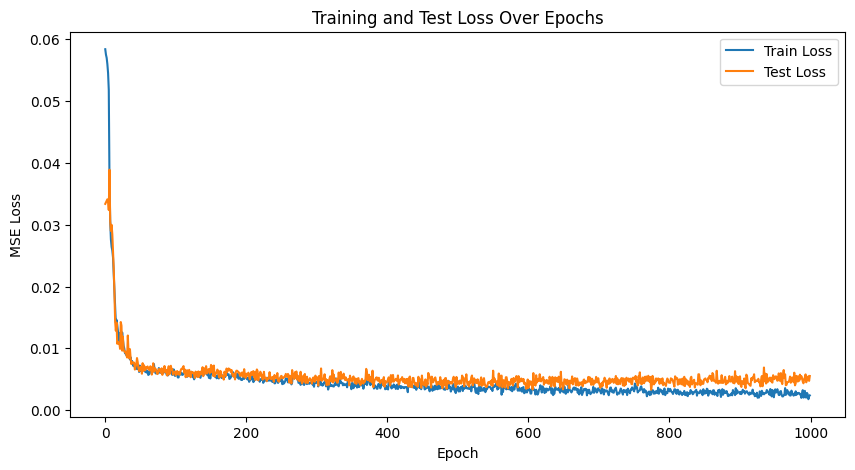

In [9]:
# Plot the training and test losses

plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Test Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

### Observation 
This plot shows that the model quickly learns to denoise the images and reaches a stable, converged performance early on. Both training and test performance remain closely matched, indicating good generalization. Beyond the first 250 epochs, additional training yields only incremental improvements, if any. And beyond 600 epoch it starts to overfit as the training loss continues to decrease slightly while the test loss stays the same or even begins to increase at some epochs, which is also evident for following visualizations as PSNR and SSIM scores (higher is better) doesn't really improve after 600 and even starts decreasing. 

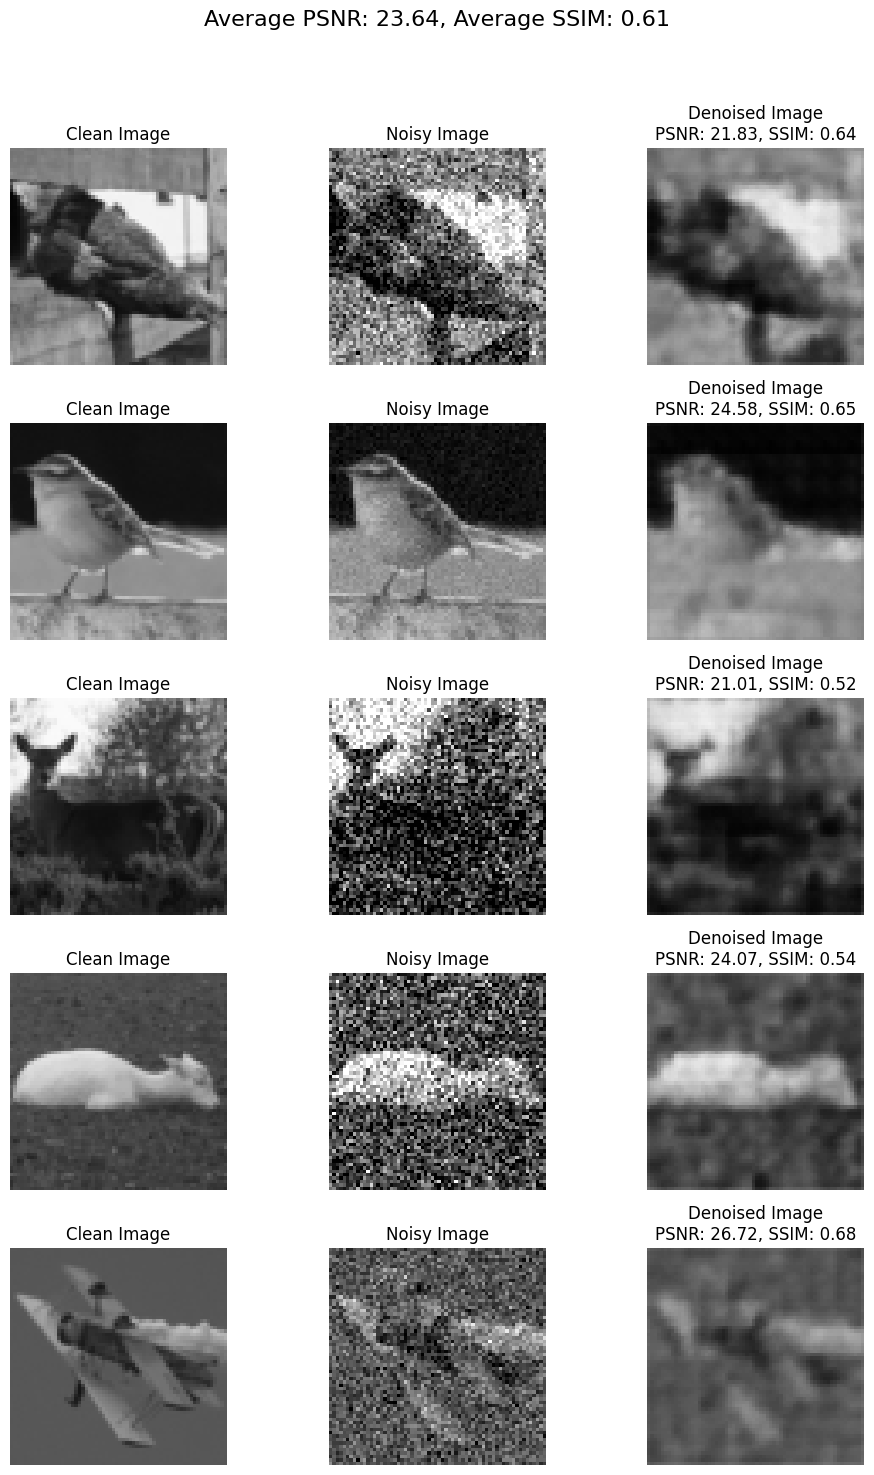

In [16]:
## Step 5: Evaluate and Visualize the Performance on Test Images
# Let's pick some test images, add noise and see how the model denoises them.
model = DenoisingAutoencoder().to(device)
model.load_state_dict(torch.load('model_weights\epoch_240_model_weights.pth')) # Load the model weights at 240th epoch
model.eval()

test_loader = DataLoader(new_test_images, batch_size=5, shuffle=False)
test_noisy_batch, test_clean_batch =  next(iter(test_loader))
test_noisy_batch = test_noisy_batch.to(device)
test_clean_batch = test_clean_batch.to(device)

with torch.no_grad():
    test_recon_batch = model(test_noisy_batch)

# Move back to CPU for visualization
test_noisy_batch = test_noisy_batch.cpu().numpy()
test_clean_batch = test_clean_batch.cpu().numpy()
test_recon_batch = test_recon_batch.cpu().numpy()

num_test_samples = test_clean_batch.shape[0]

# Compute PSNR and SSIM for each sample
psnr_values = []
ssim_values = []
for i in range(num_test_samples):
    clean_img = test_clean_batch[i,0]
    recon_img = test_recon_batch[i,0]
    # Compute metrics
    psnr_val = peak_signal_noise_ratio(clean_img, recon_img, data_range=1.0)
    ssim_val = structural_similarity(clean_img, recon_img, data_range=1.0)
    psnr_values.append(psnr_val)
    ssim_values.append(ssim_val)

avg_psnr = np.mean(psnr_values)
avg_ssim = np.mean(ssim_values)

# Visualization
plt.figure(figsize=(10, 3*num_test_samples))
plt.suptitle(f"Average PSNR: {avg_psnr:.2f}, Average SSIM: {avg_ssim:.2f}", fontsize=16)

for i in range(num_test_samples):
    # Clean Image
    plt.subplot(num_test_samples, 3, 3*i+1)
    plt.imshow(test_clean_batch[i,0], cmap='gray', vmin=0, vmax=1)
    plt.title('Clean Image')
    plt.axis('off')
    
    # Noisy Image
    plt.subplot(num_test_samples, 3, 3*i+2)
    plt.imshow(test_noisy_batch[i,0], cmap='gray', vmin=0, vmax=1)
    plt.title('Noisy Image')
    plt.axis('off')
    
    # Denoised Image with metrics
    plt.subplot(num_test_samples, 3, 3*i+3)
    plt.imshow(test_recon_batch[i,0], cmap='gray', vmin=0, vmax=1)
    # Show PSNR and SSIM for this specific image
    plt.title(f'Denoised Image\nPSNR: {psnr_values[i]:.2f}, SSIM: {ssim_values[i]:.2f}')
    plt.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit main title
plt.show()


### At 500th epoch we achieve highest metrics, PSNR of 24.03 and SSIM of 0.63, and these scores decrese to 23.65 and 0.62 at 775th epoch. This also consolidates our earlier obseration that model generalizes well before 500th epoch.
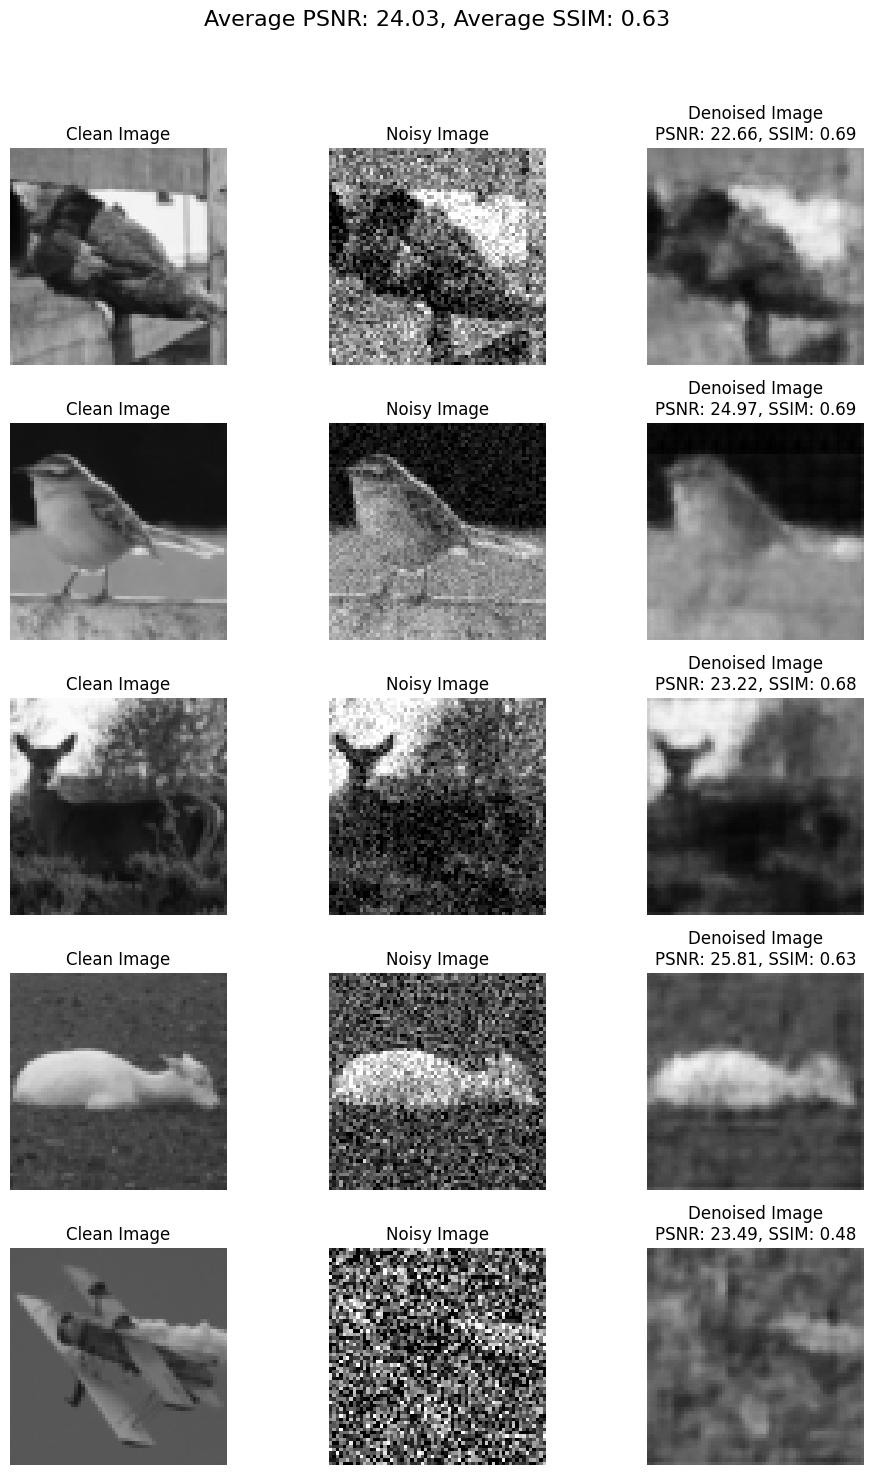

### Visualizations at 775th epoch:
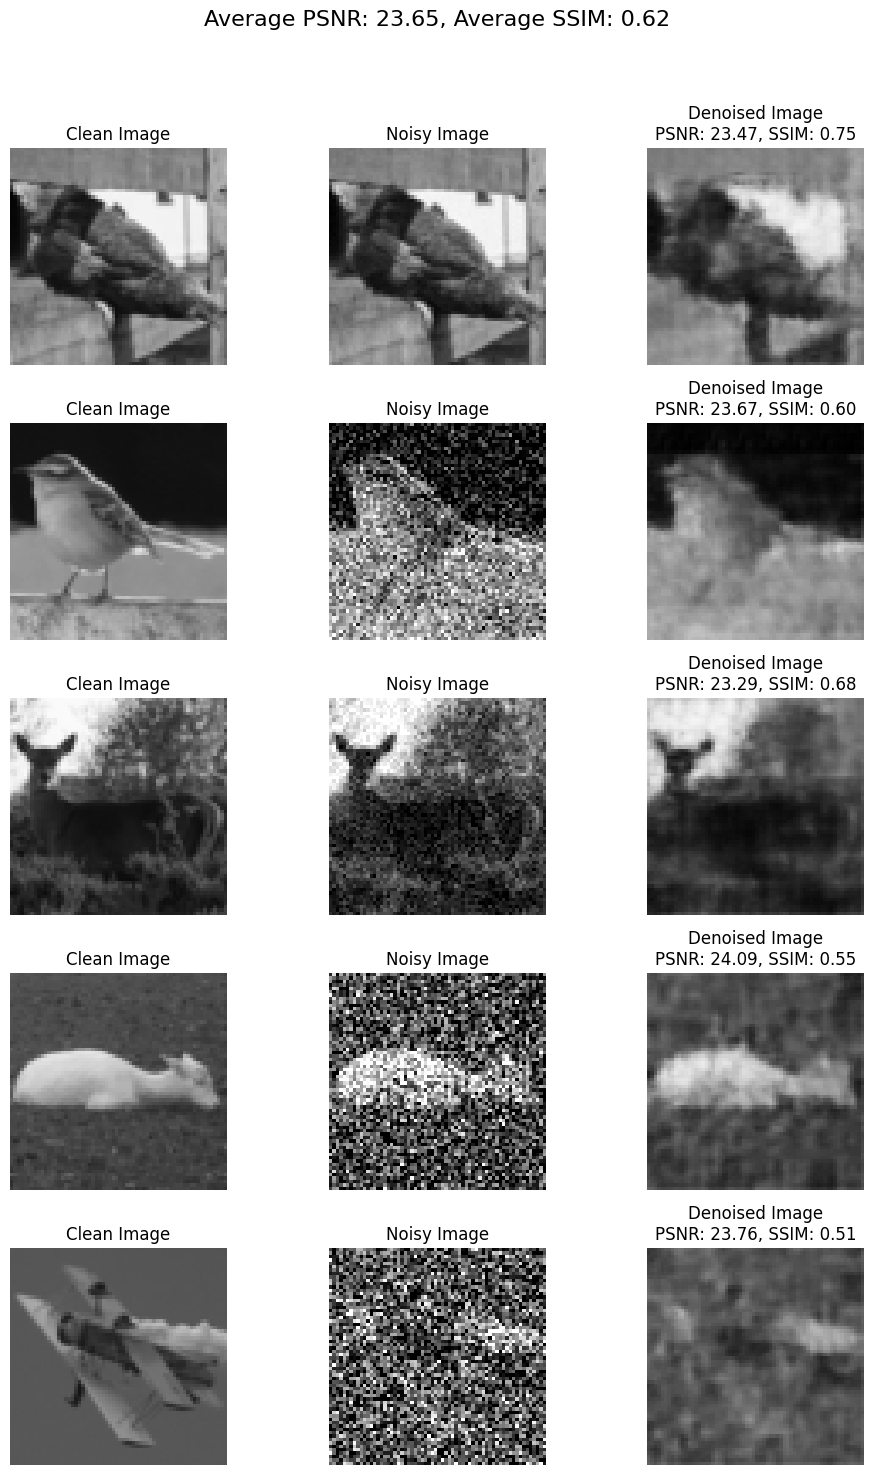